In [1]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from Nash import find_nash_equilibria_v2

In [2]:
rootdir = '../data/HuGaDB'
resultsdir = "../results/HuGaDB"

if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)

In [3]:
np.random.seed(42)
# tf.random.seed_seed(42)

### Creating Global Train set and Test set

In [4]:
# Load training and testing datasets
df_train_global = pd.concat([pd.read_csv(os.path.join(rootdir, f"train_{i+1:02d}.csv")) for i in range(10)]).dropna()
X_train_global = df_train_global.drop('act', axis=1)
y_train_global = df_train_global['act']

df_test_global = pd.concat([pd.read_csv(os.path.join(rootdir, f"test_{i+1:02d}.csv")) for i in range(10)]).dropna()
X_test_global = df_test_global.drop('act', axis=1)
y_test_global = df_test_global['act']

# Encode labels
label_encoder = LabelEncoder()
y_train_global = label_encoder.fit_transform(y_train_global)
y_test_global = label_encoder.transform(y_test_global)

# Scale features
scaler = StandardScaler()
X_train_global_scaled = scaler.fit_transform(X_train_global)
X_test_global_scaled = scaler.transform(X_test_global)


#### Centralized Training

  0%|          | 0/1 [00:00<?, ?it/s]


Confusion Matrix for Trial 1:
[[11620   151     0     1    59     2   688]
 [  141 11956     0     0    62     2   595]
 [    2     0  7550    24     0    19     0]
 [    1     0    49  1843    40     1     2]
 [   12    11     0    35 26501    36    75]
 [    2     3    61     0    86  2208     2]
 [  921   767     0     1   103     3 36666]]


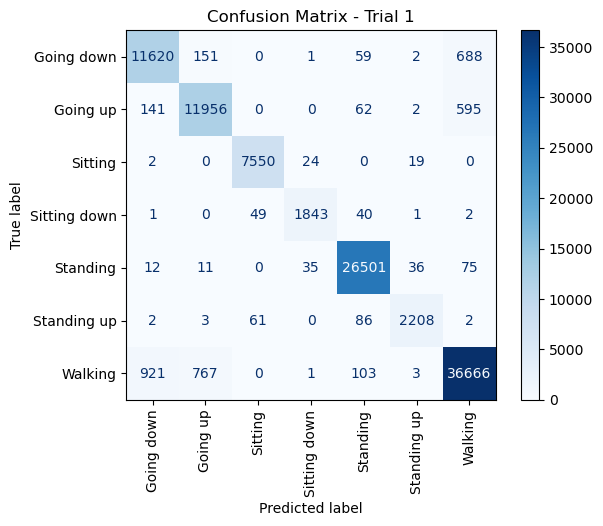

100%|██████████| 1/1 [00:24<00:00, 24.29s/it]

Trial 1/1 - Global test accuracy: 0.9613200261972024


In [5]:
# Parameters
n_trials = 1
n_trees = 10
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

results_global = []


for trial in tqdm.tqdm(range(n_trials)):

    trial_random_state = random.randint(0, 100)
    

    model = RandomForestClassifier(n_estimators=n_trees, random_state=trial_random_state)
    model.fit(X_train_global, y_train_global)
    

    y_pred = model.predict(X_test_global)
    acc_test = accuracy_score(y_test_global, y_pred)
    

    cm = confusion_matrix(y_test_global, y_pred)
    print(f"\nConfusion Matrix for Trial {trial + 1}:")
    print(cm)
    

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - Trial {trial + 1}")
    plt.show()
    

    results_global.append(acc_test)
    
    print(f"Trial {trial + 1}/{n_trials} - Global test accuracy: {acc_test}")


df_global = pd.DataFrame(results_global, columns=["accuracy"])
df_global.to_csv(os.path.join(resultsdir, "global.csv"), index=False)


#### FL

In [6]:
# Define the DecisionTree class
class DecisionTree:
    def __init__(self, max_depth=None, random_state=None):
        self.max_depth = max_depth
        self.tree_ = None
        self.random_state = random_state

    def fit(self, X, y):
        self.tree_ = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
        self.tree_.fit(X, y)

    def predict(self, X):
        return self.tree_.predict(X)

# Define the FederatedForest class
class FederatedForest:
    def __init__(self):
        self.models = []

    def add_model(self, model):
        self.models.append(model)

    def predict(self, X):
        predictions = [model.predict(X) for model in self.models]
        predictions = np.array(predictions).T
        y = [np.bincount(row).argmax() for row in predictions]
        return np.array(y)

In [7]:
# Parameters
max_depth = 10
n_clients = 10 
n_trials = 1
random_seed = 42

results = []


for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")

    np.random.seed(random_seed + trial)

    # Train models for the 10 clients
    client_models = []
    client_local_accuracies = []
    client_global_accuracies = []
    for i in range(n_clients):
        df_train_i = pd.read_csv(os.path.join(rootdir, f"train_{i+1:02d}.csv")).dropna(subset=['act'])
        X_train = df_train_i.drop('act', axis=1)
        y_train = label_encoder.transform(df_train_i['act'])

        model = DecisionTree(max_depth=max_depth, random_state=random_seed + trial)
        model.fit(X_train, y_train)
        client_models.append(model)

        # Test locally
        df_test_i = pd.read_csv(os.path.join(rootdir, f"test_{i+1:02d}.csv")).dropna(subset=['act'])
        X_test = df_test_i.drop('act', axis=1)
        y_test = label_encoder.transform(df_test_i['act'])

        # Evaluate globally
        y_pred_global = model.predict(X_test_global)
        acc_global = accuracy_score(y_test_global, y_pred_global)
        client_global_accuracies.append(acc_global)

    # Evaluate all combinations
    n_combinations = 2 ** n_clients
    for i in range(1, n_combinations):
        bin_str = format(i, f'0{n_clients}b')
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices]

        if not included_models:
            continue

        # Aggregate models
        forest = FederatedForest()
        for model in included_models:
            forest.add_model(model)

        # Global accuracy
        y_pred_global = forest.predict(X_test_global)
        acc_global = accuracy_score(y_test_global, y_pred_global)

        # Prepare the result row
        row = {
            'Trial': trial + 1,
            'Combination': bin_str,
            'Clients': [j + 1 for j in client_indices],
            'Global Accuracy': acc_global
        }

        for j in range(n_clients):
            row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]  # Accuracy on global test set
        results.append(row)

df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(resultsdir, "combinations_results_with_trials.csv"), index=False)


Trial 1/1


In [8]:
df_results = pd.read_csv(os.path.join(resultsdir, "combinations_results_with_trials.csv"))

In [9]:
df_results.sort_values(by=['Global Accuracy'], ascending=False).head(10)

,Trial,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy
1020,1,1111111101,"[1, 3, 4, 5, 6, 7, 8, 9, 10]",0.874126,0.598645,0.446281,0.598665,0.537355,0.686787,0.713825,0.665341,0.721528,0.663923,0.555254
1022,1,1111111111,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.873833,0.598645,0.446281,0.598665,0.537355,0.686787,0.713825,0.665341,0.721528,0.663923,0.555254
1021,1,1111111110,"[2, 3, 4, 5, 6, 7, 8, 9, 10]",0.870754,0.598645,0.446281,0.598665,0.537355,0.686787,0.713825,0.665341,0.721528,0.663923,0.555254
1011,1,1111110100,"[3, 5, 6, 7, 8, 9, 10]",0.870558,0.598645,0.446281,0.598665,0.537355,0.686787,0.713825,0.665341,0.721528,0.663923,0.555254
1013,1,1111110110,"[2, 3, 5, 6, 7, 8, 9, 10]",0.869610,0.598645,0.446281,0.598665,0.537355,0.686787,0.713825,0.665341,0.721528,0.663923,0.555254
500,1,111110101,"[1, 3, 5, 6, 7, 8, 9]",0.869327,0.598645,0.446281,0.598665,0.537355,0.686787,0.713825,0.665341,0.721528,0.663923,0.555254
1019,1,1111111100,"[3, 4, 5, 6, 7, 8, 9, 10]",0.869258,0.598645,0.446281,0.598665,0.537355,0.686787,0.713825,0.665341,0.721528,0.663923,0.555254
510,1,111111111,"[1, 2, 3, 4, 5, 6, 7, 8, 9]",0.868398,0.598645,0.446281,0.598665,0.537355,0.686787,0.713825,0.665341,0.721528,0.663923,0.555254
765,1,1011111110,"[2, 3, 4, 5, 6, 7, 8, 10]",0.867773,0.598645,0.446281,0.598665,0.537355,0.686787,0.713825,0.665341,0.721528,0.663923,0.555254
508,1,111111101,"[1, 3, 4, 5, 6, 7, 8, 9]",0.867509,0.598645,0.446281,0.598665,0.537355,0.686787,0.713825,0.665341,0.721528,0.663923,0.555254


In [10]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Trial,Clients,Global Accuracy
0,0000000010,1,[2],0.446281
1,1111111111,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.873833


In [ ]:
# 111111111

# TODO
# In these other coalitions, e.g,
# 111110110
# this is not a NE because someone else wants to join or because someone wants to leave?
# To find this out: print accuracy for all coalitions where somebody else joins (e.g. 111110111)
# and accuracy for all coalitions where someone leaves (e.g., 110110110)

#### MLP

In [11]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),  
    activation='relu',            
    solver='adam',                
    max_iter=300,           
    random_state=42               
)

In [12]:
def average_parameters(coefs_list, intercepts_list):
    avg_coefs = [np.mean([coef[i] for coef in coefs_list], axis=0) for i in range(len(coefs_list[0]))]
    avg_intercepts = [np.mean([intercept[i] for intercept in intercepts_list], axis=0) for i in range(len(intercepts_list[0]))]
    return avg_coefs, avg_intercepts

#### Centralized Training For MLP

Test Accuracy: 0.9333


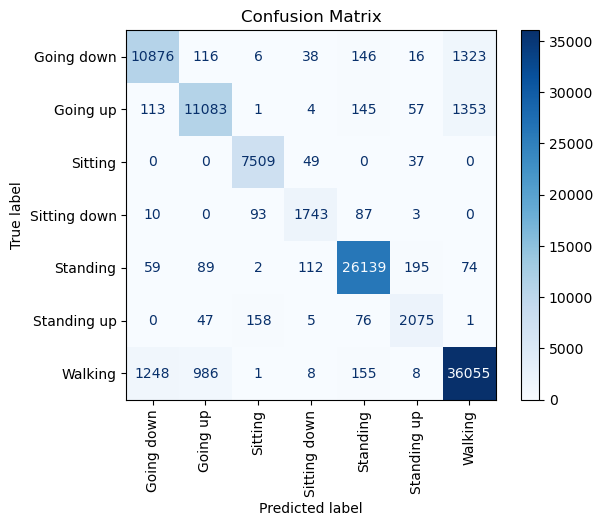

In [13]:

mlp.fit(X_train_global, y_train_global)


y_pred_global = mlp.predict(X_test_global)
accuracy_global = accuracy_score(y_test_global, y_pred_global)

print(f"Test Accuracy: {accuracy_global:.4f}")


conf_matrix = confusion_matrix(y_test_global, y_pred_global)


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')


plt.title("Confusion Matrix")
plt.show()


#### FL For MLP

In [14]:
#parameters
mlp_param = {
    "hidden_layer_sizes": (64, 32),
    "activation": "relu",
    "solver": "adam",
    "max_iter": 300, 
    "random_state": 42,
}


mlp_params = {
    "hidden_layer_sizes": (64, 32),
    "activation": "relu",
    "solver": "adam",
    "max_iter": 1, 
    "random_state": 42,
}


In [15]:
results = []
random_seed = 42
n_clients = 10

np.random.seed(random_seed)

# Train models for the 10 clients
client_models = []
client_local_accuracies = []
client_global_accuracies = []


for i in range(n_clients):
    df_train_i = pd.read_csv(os.path.join(rootdir, f"train_{i+1:02d}.csv")).dropna(subset=['act'])
    X_train = df_train_i.drop('act', axis=1)
    y_train = label_encoder.transform(df_train_i['act'])

    # Train a new MLP model for each client
    model = MLPClassifier(**mlp_param)
    model.fit(X_train, y_train)
    client_models.append(model)

    # for Test locally
    df_test_i = pd.read_csv(os.path.join(rootdir, f"test_{i+1:02d}.csv")).dropna(subset=['act'])
    X_test = df_test_i.drop('act', axis=1)
    y_test = label_encoder.transform(df_test_i['act'])

    # Evaluate locally and store accuracy
    y_pred_local = model.predict(X_test)
    acc_local = accuracy_score(y_test, y_pred_local)
    client_local_accuracies.append(acc_local)

    # Evaluate globally 
    y_pred_global = model.predict(X_test_global)
    acc_global = accuracy_score(y_test_global, y_pred_global)
    client_global_accuracies.append(acc_global)

# Evaluate all combinations
n_combinations = 2 ** n_clients
for i in range(1, n_combinations):
    bin_str = format(i, f'0{n_clients}b')
    client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
    included_models = [client_models[j] for j in client_indices]
    
    if not included_models:
        continue

    # Aggregate model parameters (averaging)
    coefs_list = [model.coefs_ for model in included_models]
    intercepts_list = [model.intercepts_ for model in included_models]
    avg_coefs, avg_intercepts = average_parameters(coefs_list, intercepts_list)

    # Create and initialize the global model
    global_model = MLPClassifier(**mlp_params)

    
    # Dummy fit to initialize
    X_dummy = X_test_global.iloc[:1]
    y_dummy = y_test_global[:1]
    global_model.partial_fit(X_dummy, y_dummy, classes=np.unique(y_test_global))

    # Set the averaged parameters
    global_model.coefs_ = avg_coefs
    global_model.intercepts_ = avg_intercepts

    # Global accuracy
    y_pred_global = global_model.predict(X_test_global)
    acc_global = accuracy_score(y_test_global, y_pred_global)

    row = {
        'Trial': 1,
        'Combination': bin_str,
        'Clients': [j + 1 for j in client_indices], 
        'Global Accuracy': acc_global
    }

    
    for j in range(n_clients):
        row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]  # Accuracy on global test set
    results.append(row)



df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(resultsdir, "mlp_combinations_results.csv"), index=False)


In [ ]:
### 
#   models = [initialize_model() for _ in range n_clients]
#   for i in range n_rounds (e.g., 10):
#       for each client
#          models[i].fit(X_local, y_local, epochs = 10)
#       average models
        #


In [25]:
df_results = pd.read_csv(os.path.join(resultsdir, "mlp_combinations_results.csv"))
pad_len = max(df_results['Combination'].apply(lambda x: len(str(x))))
df_results['Combination'] = df_results['Combination'].apply(lambda x: str(x).zfill(pad_len))

In [26]:
df_results.sort_values(by=['Global Accuracy'], ascending=False).head(5)

,Trial,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy
31,1,0000100000,[6],0.761645,0.601656,0.512683,0.585635,0.718722,0.745711,0.761645,0.68752,0.610844,0.677383,0.616025
15,1,0000010000,[5],0.745711,0.601656,0.512683,0.585635,0.718722,0.745711,0.761645,0.68752,0.610844,0.677383,0.616025
7,1,0000001000,[4],0.718722,0.601656,0.512683,0.585635,0.718722,0.745711,0.761645,0.68752,0.610844,0.677383,0.616025
63,1,0001000000,[7],0.687520,0.601656,0.512683,0.585635,0.718722,0.745711,0.761645,0.68752,0.610844,0.677383,0.616025
255,1,0100000000,[9],0.677383,0.601656,0.512683,0.585635,0.718722,0.745711,0.761645,0.68752,0.610844,0.677383,0.616025


In [18]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Trial,Clients,Global Accuracy
0,0000000001,1,[1],0.601656
1,0000000010,1,[2],0.512683
2,0001000000,1,[7],0.687520
3,0010000000,1,[8],0.610844
4,0100000000,1,[9],0.677383


Check one random singleton NE and verify that no client actually benefits from joining the coalition. 

In [40]:
ne = "0000000001"

acc = df_results[df_results["Combination"] == ne]["Global Accuracy"].iloc[0]
print(f"Accuracy of {ne} (NE): {acc:.4f}")

for i in range(pad_len):
    deviation = list(ne)
    if ne[i] != "1":
        deviation[i] = "1"
        deviation = "".join(deviation)
        acc = df_results[df_results["Combination"] == deviation]["Global Accuracy"].iloc[0]
        print(f"Accuracy of {deviation}: {acc:.4f}")

Accuracy of 0000000001 (NE): 0.6017
Accuracy of 1000000001: 0.5634
Accuracy of 0100000001: 0.4716
Accuracy of 0010000001: 0.3782
Accuracy of 0001000001: 0.3983
Accuracy of 0000100001: 0.5426
Accuracy of 0000010001: 0.4572
Accuracy of 0000001001: 0.3821
Accuracy of 0000000101: 0.5389
Accuracy of 0000000011: 0.4933


In [2]:
rootdir = '/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/'
resultsdir = "/Users/abbaszal/Documents/Thesis_Project_Spambase/results"

In [3]:
# Load training and testing datasets
df_train_global = pd.concat([pd.read_csv(os.path.join(rootdir, f"train_{i+1:02d}.csv")) for i in range(10)]).dropna()
X_train_global = df_train_global.drop('act', axis=1)
y_train_global = df_train_global['act']

df_test_global = pd.concat([pd.read_csv(os.path.join(rootdir, f"test_{i+1:02d}.csv")) for i in range(10)]).dropna()
X_test_global = df_test_global.drop('act', axis=1)
y_test_global = df_test_global['act']

# Encode labels
label_encoder = LabelEncoder()
y_train_global = label_encoder.fit_transform(y_train_global)
y_test_global = label_encoder.transform(y_test_global)

# Scale features
scaler = StandardScaler()
X_train_global_scaled = scaler.fit_transform(X_train_global)
X_test_global_scaled = scaler.transform(X_test_global)

In [12]:
import os
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Function to average model parameters
def average_parameters(models):
    """Compute FedAvg - Average model parameters across clients"""
    n_models = len(models)
    avg_coefs = [np.mean([model.coefs_[i] for model in models], axis=0) for i in range(len(models[0].coefs_))]
    avg_intercepts = [np.mean([model.intercepts_[i] for model in models], axis=0) for i in range(len(models[0].intercepts_))]
    return avg_coefs, avg_intercepts

# Parameters
mlp_params = {
    "hidden_layer_sizes": (64, 32),
    "activation": "relu",
    "solver": "adam",
    "random_state": 42,
}

# Settings
n_clients = 10
n_rounds = 10  # Number of federated training rounds
epochs_per_round = 10  # Local training epochs before sending updates
global_training_epochs = 5  # Additional training steps for the global model
random_seed = 42
np.random.seed(random_seed)


# Initialize Global Model
global_model = MLPClassifier(**mlp_params)
global_model.partial_fit(X_test_global.iloc[:1], y_test_global[:1], classes=np.unique(y_test_global))  # Dummy fit

# Store results
results = []

# Federated Training Loop
for round in range(n_rounds):
    print(f"🔄 Round {round + 1}/{n_rounds}")

    client_models = []
    client_local_accuracies = []
    client_global_accuracies = []

    # Each client trains on its local data
    for i in range(n_clients):
        df_train_i = pd.read_csv(os.path.join(rootdir, f"train_{i+1:02d}.csv")).dropna(subset=['act'])
        X_train = df_train_i.drop('act', axis=1)
        y_train = label_encoder.transform(df_train_i['act'])

        # Initialize client model with global parameters
        client_model = MLPClassifier(**mlp_params)
        client_model.partial_fit(X_train.iloc[:1], y_train[:1], classes=np.unique(y_train))  # Dummy fit
        client_model.coefs_ = global_model.coefs_
        client_model.intercepts_ = global_model.intercepts_

        # Train locally
        for epoch in range(epochs_per_round):
            client_model.partial_fit(X_train, y_train)

        # Store trained model
        client_models.append(client_model)

        # Test locally (on client's own dataset)
        df_test_i = pd.read_csv(os.path.join(rootdir, f"test_{i+1:02d}.csv")).dropna(subset=['act'])
        X_test = df_test_i.drop('act', axis=1)
        y_test = label_encoder.transform(df_test_i['act'])

        # Evaluate local accuracy
        y_pred_local = client_model.predict(X_test)
        acc_local = accuracy_score(y_test, y_pred_local)
        client_local_accuracies.append(acc_local)

        # Evaluate on global test set
        y_pred_global = client_model.predict(X_test_global)
        acc_global = accuracy_score(y_test_global, y_pred_global)
        client_global_accuracies.append(acc_global)

    # Aggregate models using FedAvg
    avg_coefs, avg_intercepts = average_parameters(client_models)

    # Update Global Model with Averaged Parameters
    global_model.coefs_ = avg_coefs
    global_model.intercepts_ = avg_intercepts

    # 🔹 Train Global Model for a Few More Steps on Aggregated Parameters
    for epoch in range(global_training_epochs):
        global_model.partial_fit(X_test_global, y_test_global)

    # Evaluate Global Model after this round
    y_pred_global = global_model.predict(X_test_global)
    acc_global = accuracy_score(y_test_global, y_pred_global)
    print(f" Global Model Accuracy after Round {round + 1}: {acc_global:.4f}")

    # Evaluate all client combinations
    n_combinations = 2 ** n_clients
    for i in range(1, n_combinations):
        bin_str = format(i, f'0{n_clients}b')
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices]

        if not included_models:
            continue

        # Aggregate model parameters (averaging)
        coefs_list = [model.coefs_ for model in included_models]
        intercepts_list = [model.intercepts_ for model in included_models]
        avg_coefs, avg_intercepts = average_parameters(included_models)

        # Create and initialize the global model for this combination
        temp_global_model = MLPClassifier(**mlp_params)
        temp_global_model.partial_fit(X_test_global.iloc[:1], y_test_global[:1], classes=np.unique(y_test_global))  # Dummy fit

        # Set the averaged parameters
        temp_global_model.coefs_ = avg_coefs
        temp_global_model.intercepts_ = avg_intercepts

        # Global accuracy for this combination
        y_pred_global = temp_global_model.predict(X_test_global)
        acc_global = accuracy_score(y_test_global, y_pred_global)

        # Store results
        row = {
            'Trial': round + 1,
            'Combination': bin_str,
            'Clients': [j + 1 for j in client_indices], 
            'Global Accuracy': acc_global
        }
        for j in range(n_clients):
            row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]  # Accuracy on global test set
        results.append(row)

# Convert results to DataFrame and save to CSV
df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(resultsdir, "rounded_mlp_combinations_results.csv"), index=False)

print("Federated Learning Complete! Results saved.")


🔄 Round 1/10
 Global Model Accuracy after Round 1: 0.9503
🔄 Round 2/10
 Global Model Accuracy after Round 2: 0.9536
🔄 Round 3/10
 Global Model Accuracy after Round 3: 0.9551
🔄 Round 4/10
 Global Model Accuracy after Round 4: 0.9560
🔄 Round 5/10
 Global Model Accuracy after Round 5: 0.9569
🔄 Round 6/10
 Global Model Accuracy after Round 6: 0.9576
🔄 Round 7/10
 Global Model Accuracy after Round 7: 0.9580
🔄 Round 8/10
 Global Model Accuracy after Round 8: 0.9578
🔄 Round 9/10
 Global Model Accuracy after Round 9: 0.9583
🔄 Round 10/10
 Global Model Accuracy after Round 10: 0.9580
Federated Learning Complete! Results saved.


In [15]:
import os
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Function to average model parameters
def average_parameters(models):
    """Compute FedAvg - Average model parameters across selected clients"""
    n_models = len(models)
    avg_coefs = [np.mean([model.coefs_[i] for model in models], axis=0) for i in range(len(models[0].coefs_))]
    avg_intercepts = [np.mean([model.intercepts_[i] for model in models], axis=0) for i in range(len(models[0].intercepts_))]
    return avg_coefs, avg_intercepts

# Parameters
mlp_params = {
    "hidden_layer_sizes": (64, 32),
    "activation": "relu",
    "solver": "adam",
    "random_state": 42,
}

# Settings
n_clients = 10
n_rounds = 10  # Number of federated training rounds
epochs_per_round = 10  # Local training epochs before sending updates
global_training_epochs = 5  # Additional training steps for the global model
random_seed = 42
np.random.seed(random_seed)


# Initialize Global Model
global_model = MLPClassifier(**mlp_params)
global_model.partial_fit(X_test_global.iloc[:1], y_test_global[:1], classes=np.unique(y_test_global))  # Dummy fit

# Store results
results = []

# Federated Training Loop
for round in range(n_rounds):
    print(f" Round {round + 1}/{n_rounds}")

    client_models = []
    client_global_accuracies = []

    # Each client trains on its local data
    for i in range(n_clients):
        df_train_i = pd.read_csv(os.path.join(rootdir, f"train_{i+1:02d}.csv")).dropna(subset=['act'])
        X_train = df_train_i.drop('act', axis=1)
        y_train = label_encoder.transform(df_train_i['act'])

        # Initialize client model with global parameters
        client_model = MLPClassifier(**mlp_params)
        client_model.partial_fit(X_train.iloc[:1], y_train[:1], classes=np.unique(y_train))  # Dummy fit
        client_model.coefs_ = global_model.coefs_
        client_model.intercepts_ = global_model.intercepts_

        # Train locally
        for epoch in range(epochs_per_round):
            client_model.partial_fit(X_train, y_train)

        # Store trained model
        client_models.append(client_model)

        # Evaluate on global test set
        y_pred_global = client_model.predict(X_test_global)
        acc_global = accuracy_score(y_test_global, y_pred_global)
        client_global_accuracies.append(acc_global)

    # Aggregate models using FedAvg
    avg_coefs, avg_intercepts = average_parameters(client_models)

    # Update Global Model with Averaged Parameters
    global_model.coefs_ = avg_coefs
    global_model.intercepts_ = avg_intercepts

    # 🔹 Train Global Model for a Few More Steps on Aggregated Parameters
    for epoch in range(global_training_epochs):
        global_model.partial_fit(X_test_global, y_test_global)

    # Only evaluate all client combinations **after the last round**
    if round == n_rounds - 1:
        n_combinations = 2 ** n_clients
        for i in range(1, n_combinations):
            bin_str = format(i, f'0{n_clients}b')
            client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
            included_models = [client_models[j] for j in client_indices]

            if not included_models:
                continue

            # Aggregate model parameters (averaging) only for included clients
            avg_coefs, avg_intercepts = average_parameters(included_models)

            # Create and initialize a new global model for this subset
            temp_global_model = MLPClassifier(**mlp_params)
            temp_global_model.partial_fit(X_test_global.iloc[:1], y_test_global[:1], classes=np.unique(y_test_global))  # Dummy fit

            # Set the averaged parameters
            temp_global_model.coefs_ = avg_coefs
            temp_global_model.intercepts_ = avg_intercepts

            # Compute **new** global accuracy using only the selected clients' models
            y_pred_global = temp_global_model.predict(X_test_global)
            acc_global = accuracy_score(y_test_global, y_pred_global)

            # Store results
            row = {
                'Trial': round + 1,
                'Combination': bin_str,
                'Clients': [j + 1 for j in client_indices], 
                'Global Accuracy': acc_global  #  Only for included clients
            }

            #  Store only included clients' accuracy
            for j in range(n_clients):
                row[f'Client {j + 1} Accuracy'] = client_global_accuracies[j]  # Only for selected clients

            results.append(row)

        # Convert results to DataFrame and save to CSV
        df_results = pd.DataFrame(results)
        df_results.to_csv(os.path.join(resultsdir, "mlp_combinations_results.csv"), index=False)

        print(" Final Results Saved: mlp_combinations_results.csv")


🔄 Round 1/10
🔄 Round 2/10
🔄 Round 3/10
🔄 Round 4/10
🔄 Round 5/10
🔄 Round 6/10
🔄 Round 7/10
🔄 Round 8/10
🔄 Round 9/10
🔄 Round 10/10
✅ Final Results Saved: mlp_combinations_results.csv


In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Define MLP parameters
mlp_params = {
    "hidden_layer_sizes": (64, 32),
    "activation": "relu",
    "solver": "adam",
    "random_state": 42,
}

# Training settings
n_clients = 10  # Number of clients
n_rounds = 10  # Number of federated rounds per combination
epochs_per_round = 10  # Local epochs before aggregation
global_training_epochs = 5  # Extra training epochs for the global model
random_seed = 42
np.random.seed(random_seed)


# Function to compute FedAvg (Federated Averaging)
def average_parameters(models):
    """Compute the average of model parameters across selected clients (FedAvg)."""
    avg_coefs = [np.mean([model.coefs_[i] for model in models], axis=0) for i in range(len(models[0].coefs_))]
    avg_intercepts = [np.mean([model.intercepts_[i] for model in models], axis=0) for i in range(len(models[0].intercepts_))]
    return avg_coefs, avg_intercepts

# Store all results
all_results = []

# Generate all possible client combinations using binary representation
n_combinations = 2 ** n_clients  # Total number of combinations (excluding empty set)
for i in range(1, n_combinations):  # Start from 1 to avoid the empty set
    bin_str = format(i, f'0{n_clients}b')  # Binary representation of the combination
    client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']  # Extract client indices

    print(f"\n Starting Training for Combination: {bin_str} (Clients: {client_indices})")

    # Initialize global model
    global_model = MLPClassifier(**mlp_params)
    global_model.partial_fit(X_test_global.iloc[:1], y_test_global[:1], classes=np.unique(y_test_global))  # Dummy fit

    # Store results for this combination
    combination_results = []

    # Run federated learning for `n_rounds` for the current client combination
    for round_idx in range(n_rounds):
        print(f" Round {round_idx + 1}/{n_rounds} for Clients {client_indices}")

        # Store client models and their global accuracy
        client_models = []
        client_global_accuracies = {}

        # Each selected client trains its local model
        for client_id in client_indices:
            df_train_i = pd.read_csv(os.path.join(rootdir, f"train_{client_id+1:02d}.csv")).dropna(subset=['act'])
            X_train = df_train_i.drop('act', axis=1)
            y_train = label_encoder.transform(df_train_i['act'])

            # Initialize a new client model with global parameters
            client_model = MLPClassifier(**mlp_params)
            client_model.partial_fit(X_train.iloc[:1], y_train[:1], classes=np.unique(y_train))  # Dummy fit

            # Use the latest global model parameters
            client_model.coefs_ = global_model.coefs_
            client_model.intercepts_ = global_model.intercepts_

            # Train locally for the given epochs
            for epoch in range(epochs_per_round):
                client_model.partial_fit(X_train, y_train)

            # Store the trained client model
            client_models.append(client_model)

            # Evaluate model on global test set
            y_pred_global = client_model.predict(X_test_global)
            acc_global = accuracy_score(y_test_global, y_pred_global)
            client_global_accuracies[client_id] = acc_global

        # Perform FedAvg (Federated Averaging) to aggregate parameters
        avg_coefs, avg_intercepts = average_parameters(client_models)

        # Update Global Model with Averaged Parameters
        global_model = MLPClassifier(**mlp_params)
        global_model.partial_fit(X_test_global.iloc[:1], y_test_global[:1], classes=np.unique(y_test_global))  # Dummy fit
        global_model.coefs_ = avg_coefs
        global_model.intercepts_ = avg_intercepts

        # Further train the global model on the aggregated parameters
        for epoch in range(global_training_epochs):
            global_model.partial_fit(X_test_global, y_test_global)

        # Save results for this round in this combination
        row = {
            'Round': round_idx + 1,
            'Combination': bin_str,
            'Clients': [client_id + 1 for client_id in client_indices],
            'Global Accuracy': accuracy_score(y_test_global, global_model.predict(X_test_global))
        }

        # Store individual client accuracies
        for client_id in range(n_clients):
            row[f'Client {client_id + 1} Accuracy'] = client_global_accuracies.get(client_id, None)

        combination_results.append(row)

    # Convert results of this combination to DataFrame and append to all results
    df_combination_results = pd.DataFrame(combination_results)
    all_results.append(df_combination_results)

# Concatenate all combination results into a single DataFrame
df_all_results = pd.concat(all_results, ignore_index=True)

# Save final results to CSV
df_all_results.to_csv(os.path.join(resultsdir, "mlp_federated_results.csv"), index=False)
print("\n Final results saved to mlp_federated_results.csv")



 Starting Training for Combination: 0000000001 (Clients: [0])
 Round 1/10 for Clients [0]
 Round 2/10 for Clients [0]
 Round 3/10 for Clients [0]
 Round 4/10 for Clients [0]
 Round 5/10 for Clients [0]
 Round 6/10 for Clients [0]
 Round 7/10 for Clients [0]
 Round 8/10 for Clients [0]
 Round 9/10 for Clients [0]
 Round 10/10 for Clients [0]

 Starting Training for Combination: 0000000010 (Clients: [1])
 Round 1/10 for Clients [1]
 Round 2/10 for Clients [1]
 Round 3/10 for Clients [1]
 Round 4/10 for Clients [1]
 Round 5/10 for Clients [1]
 Round 6/10 for Clients [1]
 Round 7/10 for Clients [1]
 Round 8/10 for Clients [1]
 Round 9/10 for Clients [1]
 Round 10/10 for Clients [1]

 Starting Training for Combination: 0000000011 (Clients: [0, 1])
 Round 1/10 for Clients [0, 1]
 Round 2/10 for Clients [0, 1]
 Round 3/10 for Clients [0, 1]
 Round 4/10 for Clients [0, 1]
 Round 5/10 for Clients [0, 1]
 Round 6/10 for Clients [0, 1]
 Round 7/10 for Clients [0, 1]
 Round 8/10 for Clients [0, 1

KeyboardInterrupt: 